In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

from matplotlib import rcParams

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('default')  

#-- 
#https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

import warnings
warnings.filterwarnings('ignore')

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
sc.settings.set_figure_params(dpi=80)

In [56]:
#--- object before correction
adata_Scrublet= sc.read('./H5AD/iVacc_BC_110319.h5ad')
adata_Scrublet

AnnData object with n_obs × n_vars = 82153 × 2364 
    obs: 'Age', 'Gender', 'Race', 'Groups', 'Subjects', 'Batches', 'IDs', 'doublet_score', 'predicted_doublets_1', 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Batches_colors', 'Groups_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [64]:
#--------------------- 10 BATCHES : BBKNN batch correction
import bbknn
#--- bbkkn batch correction --> 10X batches 
corrected = bbknn.bbknn(adata_Scrublet, 
                        copy=True, 
                        batch_key="IDs", 
                        metric="angular", 
                        approx=True,
                        neighbors_within_batch=5, 
                        n_pcs=20, 
                        trim=50)


computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:01:01)


In [65]:
#--- UMAP on corrected data 
sc.tl.umap(corrected, 
           min_dist=0.3,
           n_components=3)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:05)


In [66]:
#--- louvain on corrected data
sc.tl.louvain(corrected, 
              resolution=1.2) #default , resolution = 1


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:01:20)


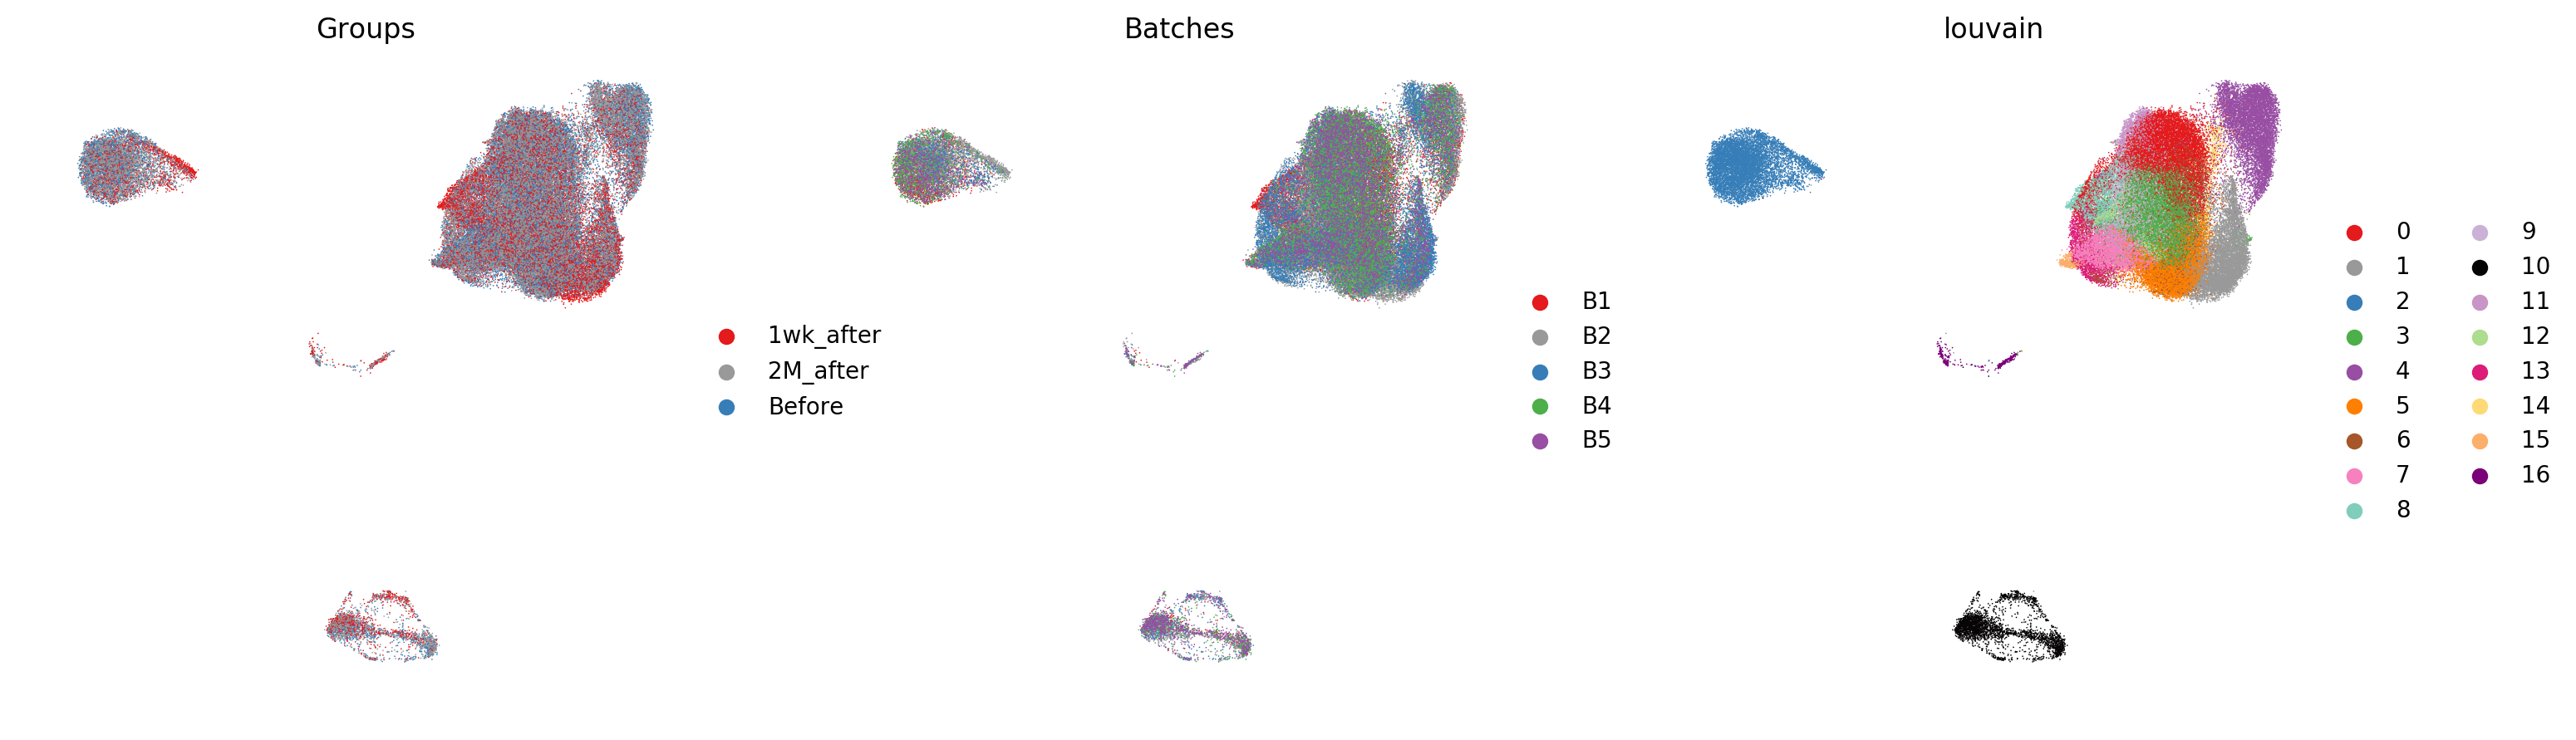

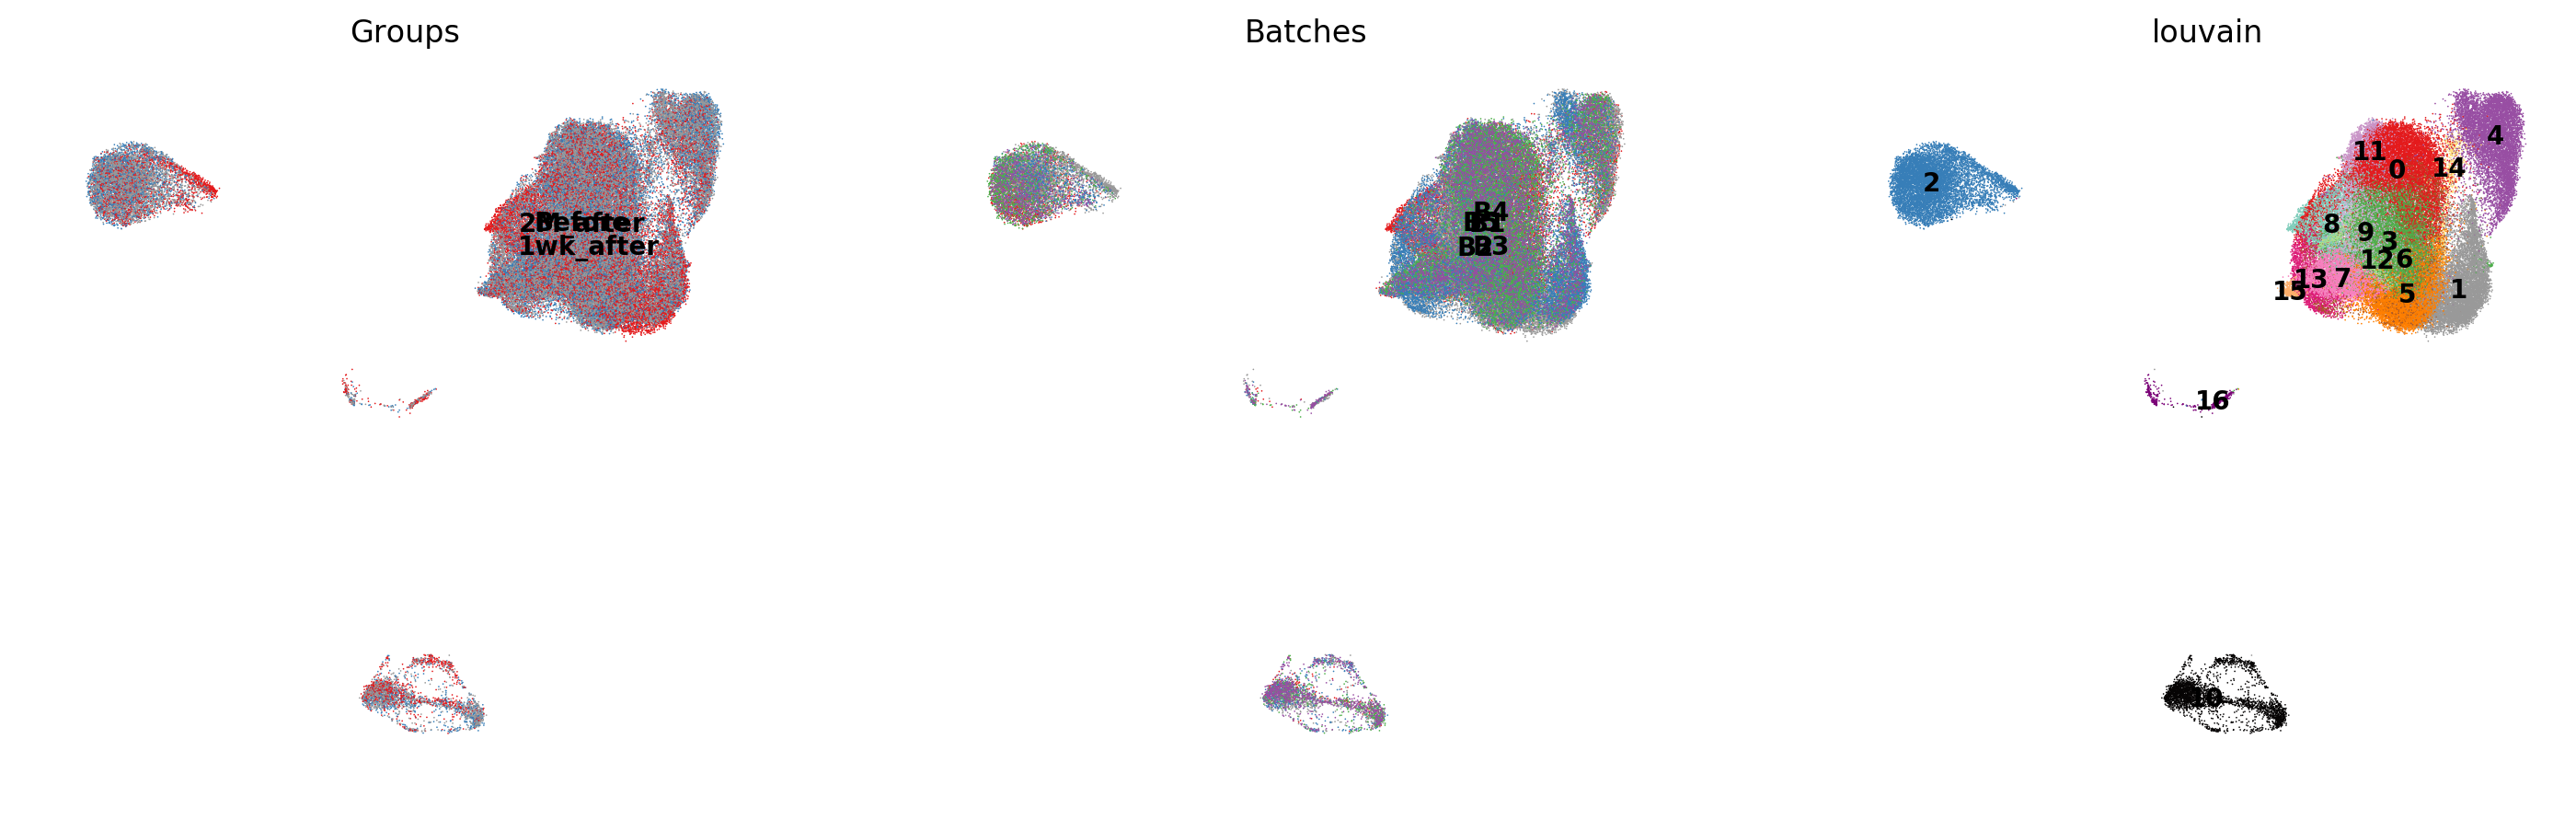

In [67]:
#----------------- AFETR 10X batches  CORRECTION

rcParams['figure.figsize'] = (5,5)

sc.pl.umap(corrected, color=['Groups','Batches','louvain']Subjectsameon=False)
sc.pl.umap(corrected, color=['Groups', 'Batches','louvain'],
           frameon=False,legend_loc='on data',legend_fontsize=10)



In [68]:
corrected.uns['Groups_colors']

['#e41a1c', '#999999', '#377eb8']

In [69]:

col_ids =['tomato','paleturquoise','cornflowerblue','mediumseagreen','mediumpurple','goldenrod','lightgreen','palevioletred','lightsalmon','thistle', #0-9
          "brown","plum","lightskyblue","yellowgreen","mediumorchid","mediumturquoise","peru","darkviolet","mediumaquamarine","lightslategrey","dodgerblue"]
col_groups =['mediumaquamarine','lightsalmon','lightskyblue','tomato']


corrected.uns['Batches_colors']= col_ids
corrected.uns['louvain_colors']= col_ids
corrected.uns['clusters_colors']= col_ids
corrected.uns['Groups_colors']= col_groups



In [52]:
#--- save embeddings AFTER CORRECTION

#--- Umap embbedings 
Emb = corrected.obsm.to_df()[['X_umap1', 'X_umap2', 'X_umap3']]
Emb.index = corrected.obs.index

#-- Meta Data 
meta = corrected.obs
Mat = meta.join(Emb)
Mat.to_csv('./meta/Meta_iVacc_AC_110419.csv')

corrected.write('./H5AD/iVacc_AC_1110419.h5ad')

AnnData object with n_obs × n_vars = 82153 × 2364 
    obs: 'Age', 'Gender', 'Race', 'Groups', 'Subjects', 'Batches', 'IDs', 'doublet_score', 'predicted_doublets_1', 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors', 'Groups_colors', 'Batches_colors', 'clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

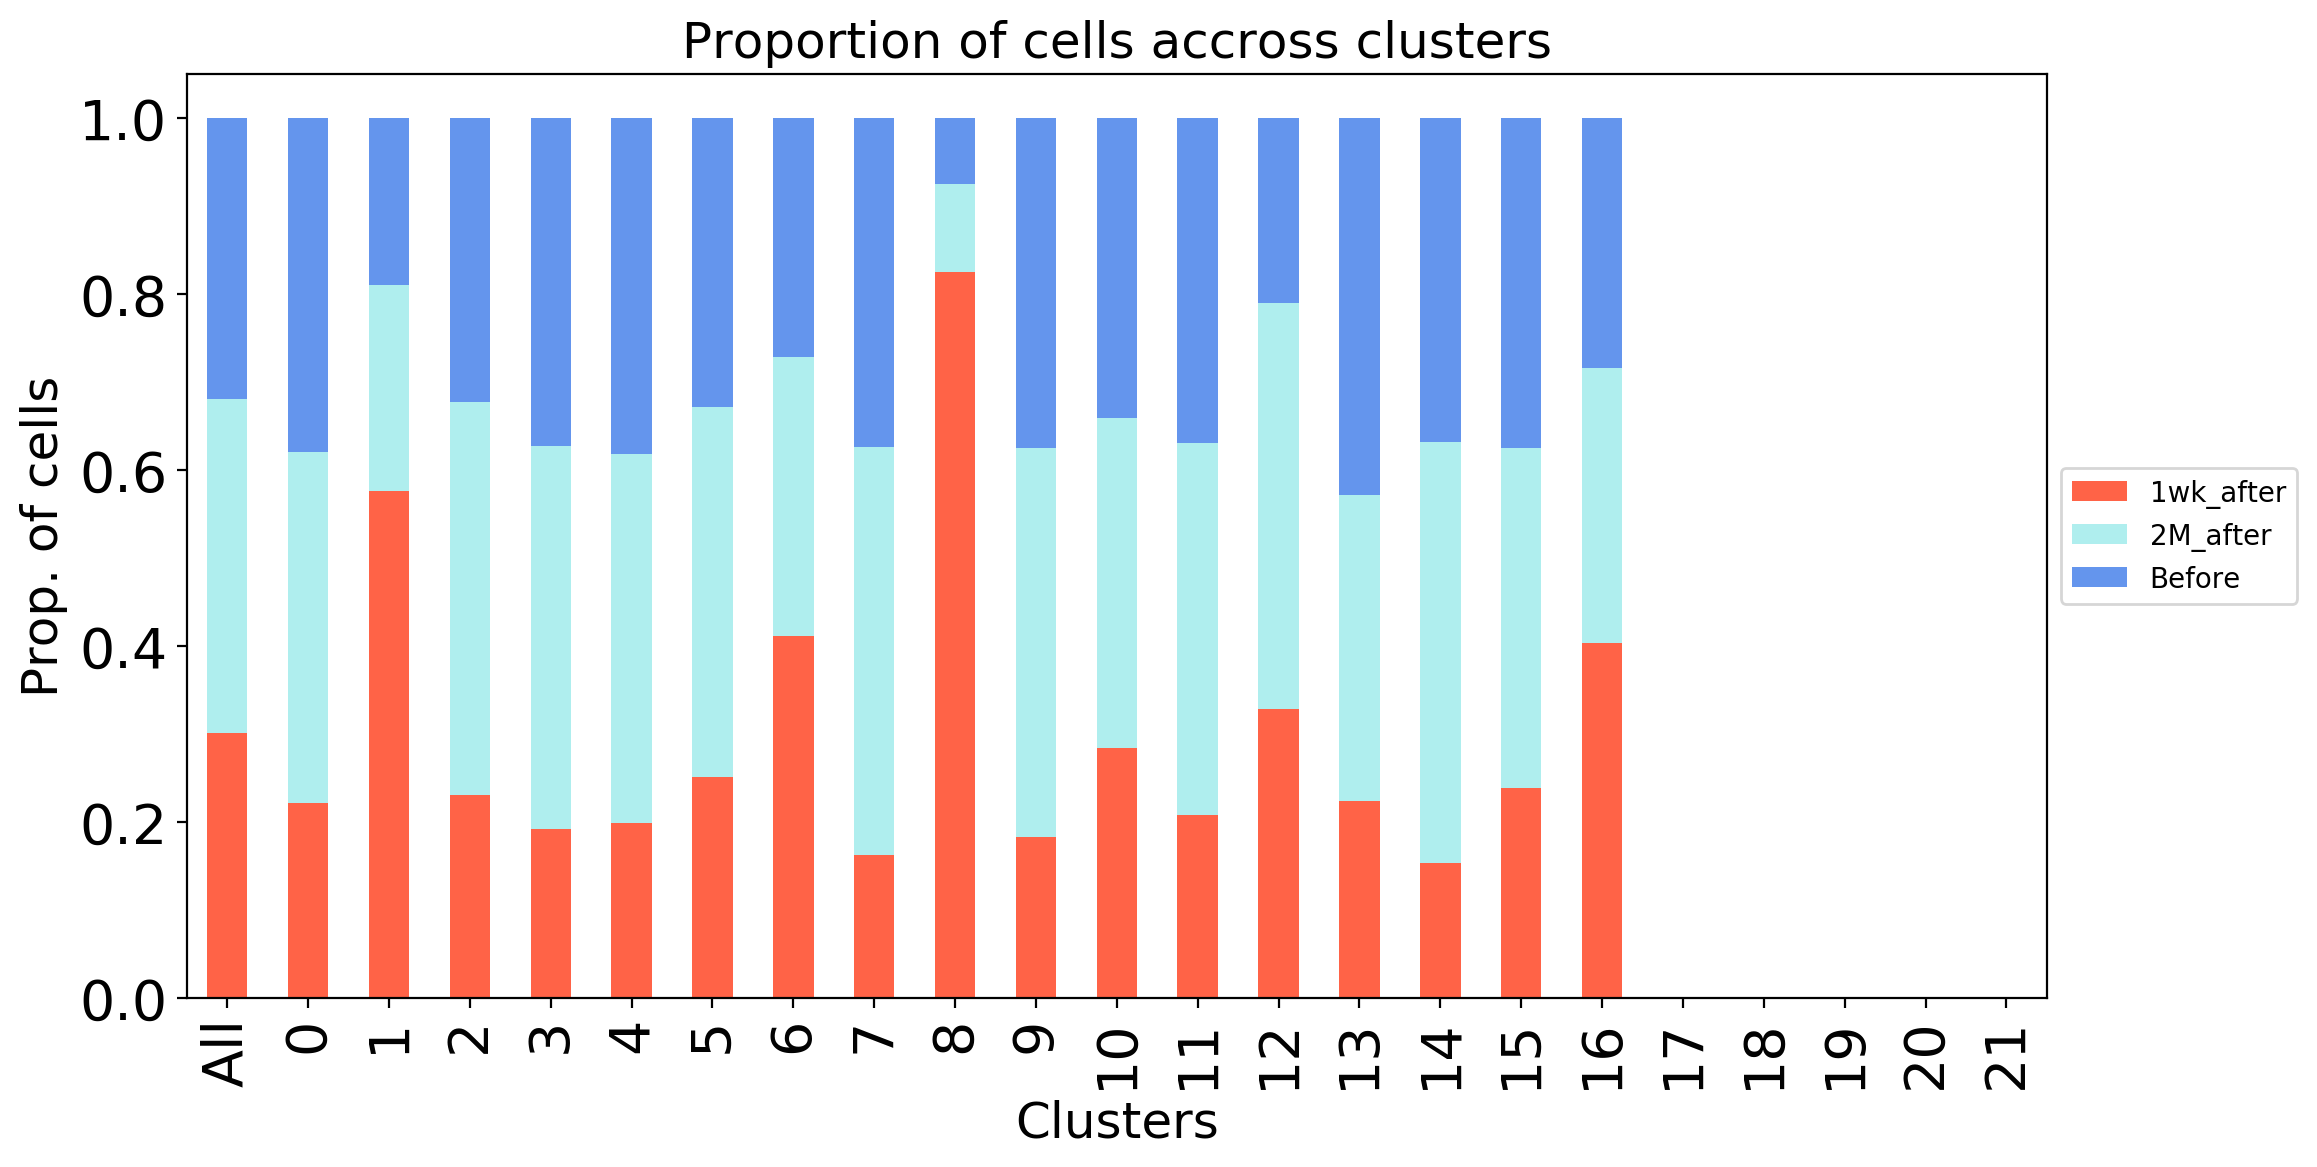

In [70]:
#-- proportion table
Groups_tab = pd.crosstab(index=corrected.obs['louvain'],  # Make a crosstab
                        columns=corrected.obs['Groups'], margins=True)               # Name the count column


#-- change index and columns order
Groups_tab = Groups_tab.reindex(['All','0','1','2','3','4','5','6','7','8','9','10','11','12',
                                 '13','14','15','16','17','18','19','20','21'])
#Groups_tab = Groups_tab[['SLE','HD','All']]

MyTab= Groups_tab.div(Groups_tab["All"], axis=0)
MyTab2 = MyTab.drop(columns="All")

MyTab2.plot(kind="bar",
            figsize=(12,6),
            stacked=True, 
            linewidth=1, 
            width=0.5, 
            fontsize=20, 
            color=col_ids)


plt.title("Proportion of cells accross clusters", fontsize=18)
plt.ylabel("Prop. of cells", fontsize=18)
plt.xlabel("Clusters", fontsize=18)
plt.ylim=1.0

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.show()



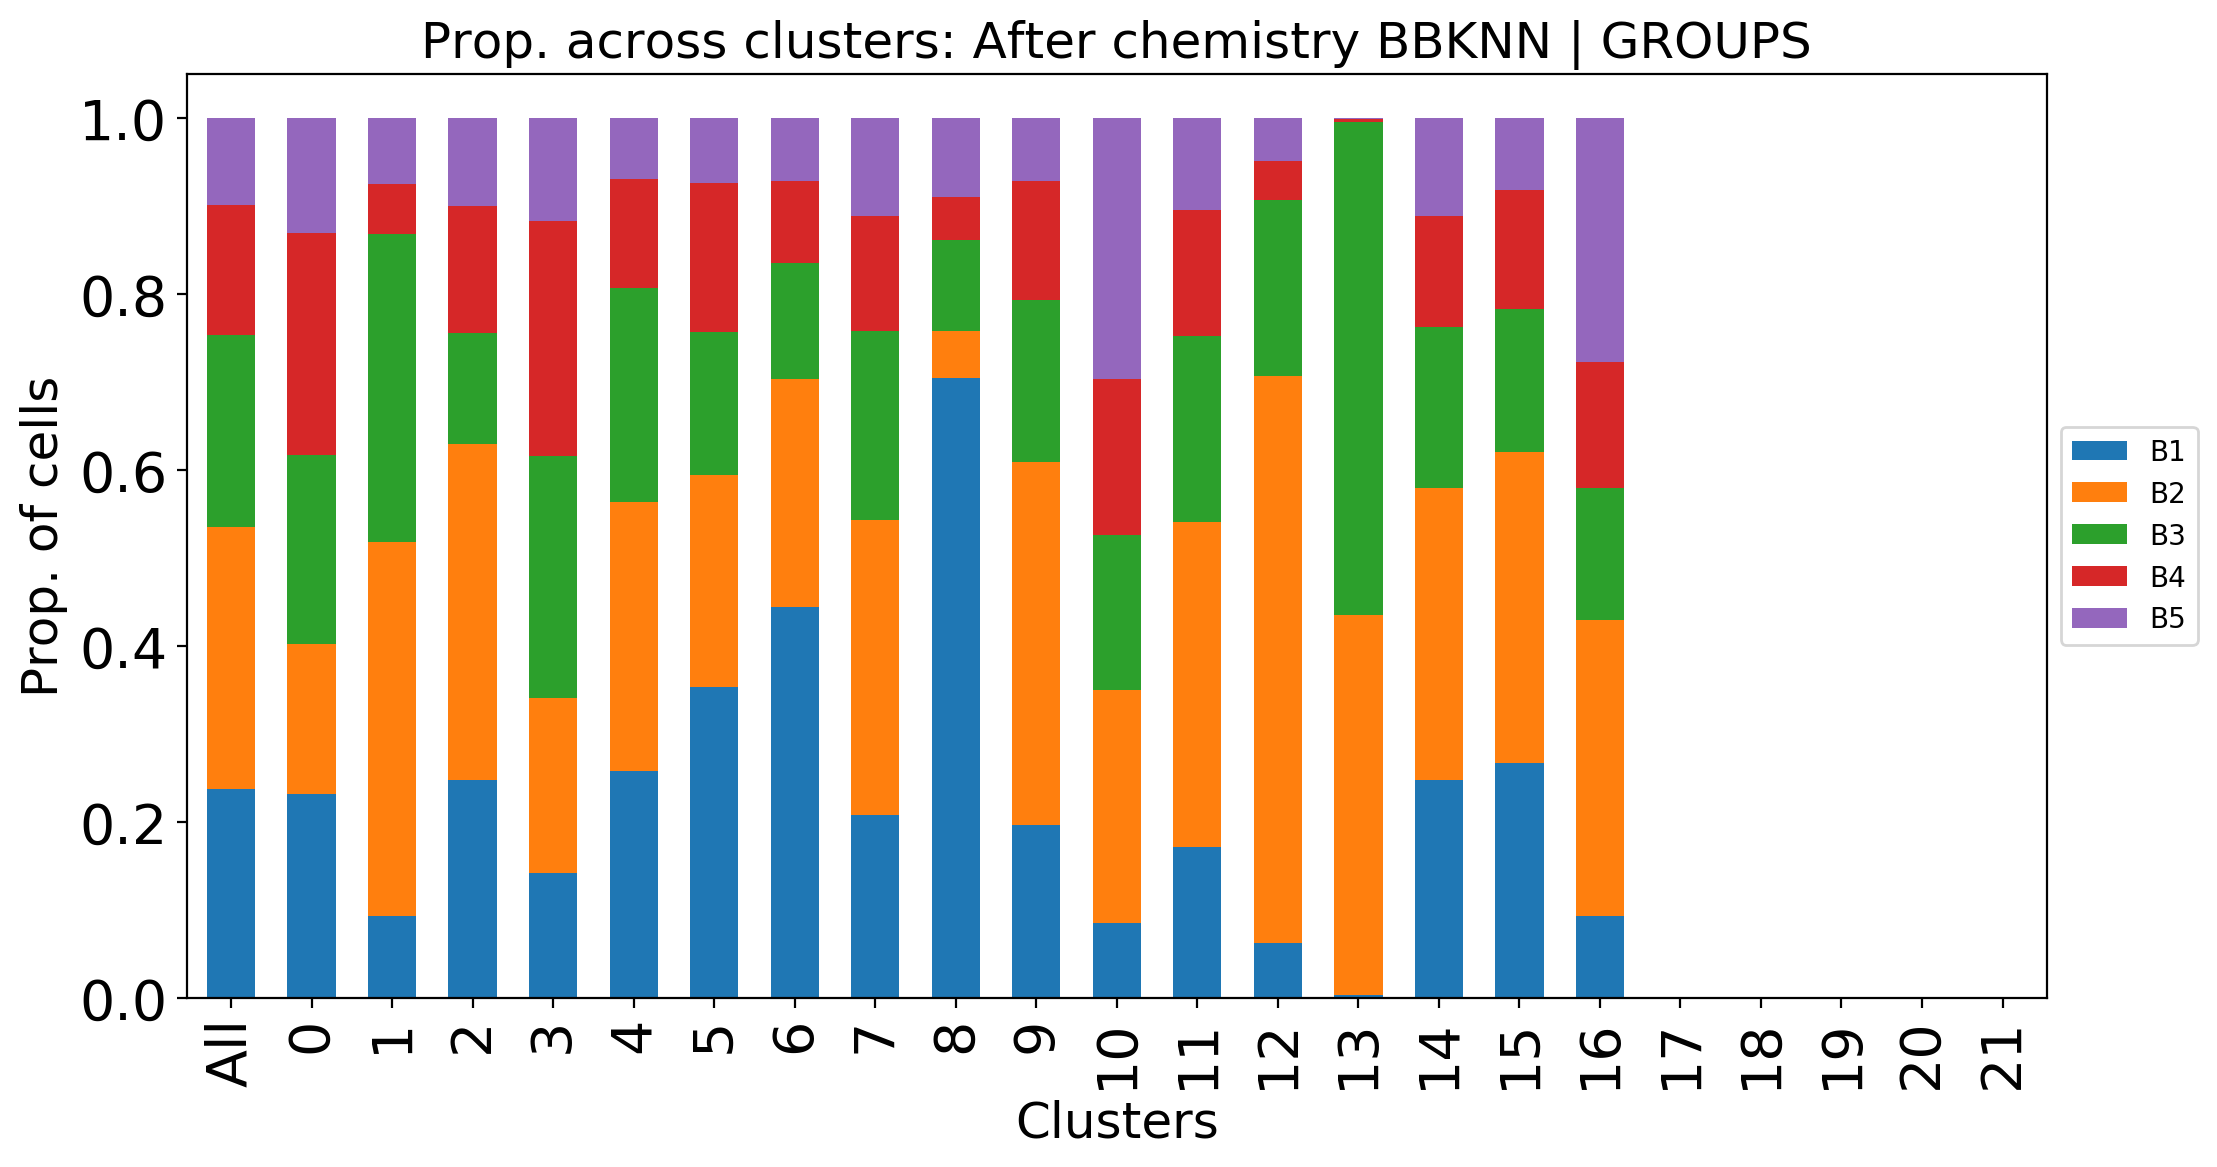

In [71]:
#-- proportion table
Groups_tab = pd.crosstab(index=corrected.obs['louvain'],  # Make a crosstab
                        columns=corrected.obs['Batches'], margins=True)               # Name the count column


#-- change index and columns order
Groups_tab = Groups_tab.reindex(['All','0','1','2','3','4','5','6','7','8','9','10','11','12',
                                 '13','14','15','16','17','18','19','20','21'])
#Groups_tab = Groups_tab[['HI','HC','HY','HO','All']]

MyTab= Groups_tab.div(Groups_tab["All"], axis=0)
MyTab2 = MyTab.drop(columns="All")

MyTab2.plot(kind="bar",
            figsize=(12,6),
            stacked=True, 
            linewidth=1, 
            width=0.6, 
            fontsize=20)

plt.title("Prop. across clusters: After chemistry BBKNN | GROUPS", fontsize=18)
plt.ylabel("Prop. of cells", fontsize=18)
plt.xlabel("Clusters", fontsize=18)
plt.ylim=1.0

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.show()



In [85]:
#adata_SC = sc.read('./H5AD/LifeSpan_AS_BF_BC_100819.h5ad')
#adata_SC.obs.to_csv('./Meta/Meta_LifeSpan_AS_BF_BC_100819')

In [86]:
corrected

AnnData object with n_obs × n_vars = 82153 × 2364 
    obs: 'Age', 'Gender', 'Race', 'Groups', 'Subjects', 'Batches', 'IDs', 'doublet_score', 'predicted_doublets_1', 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors', 'Groups_colors', 'Batches_colors', 'clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_louvain']`
categories: 0, 1, 2, etc.
var_group_labels: Mono, DCs, T cells, etc.


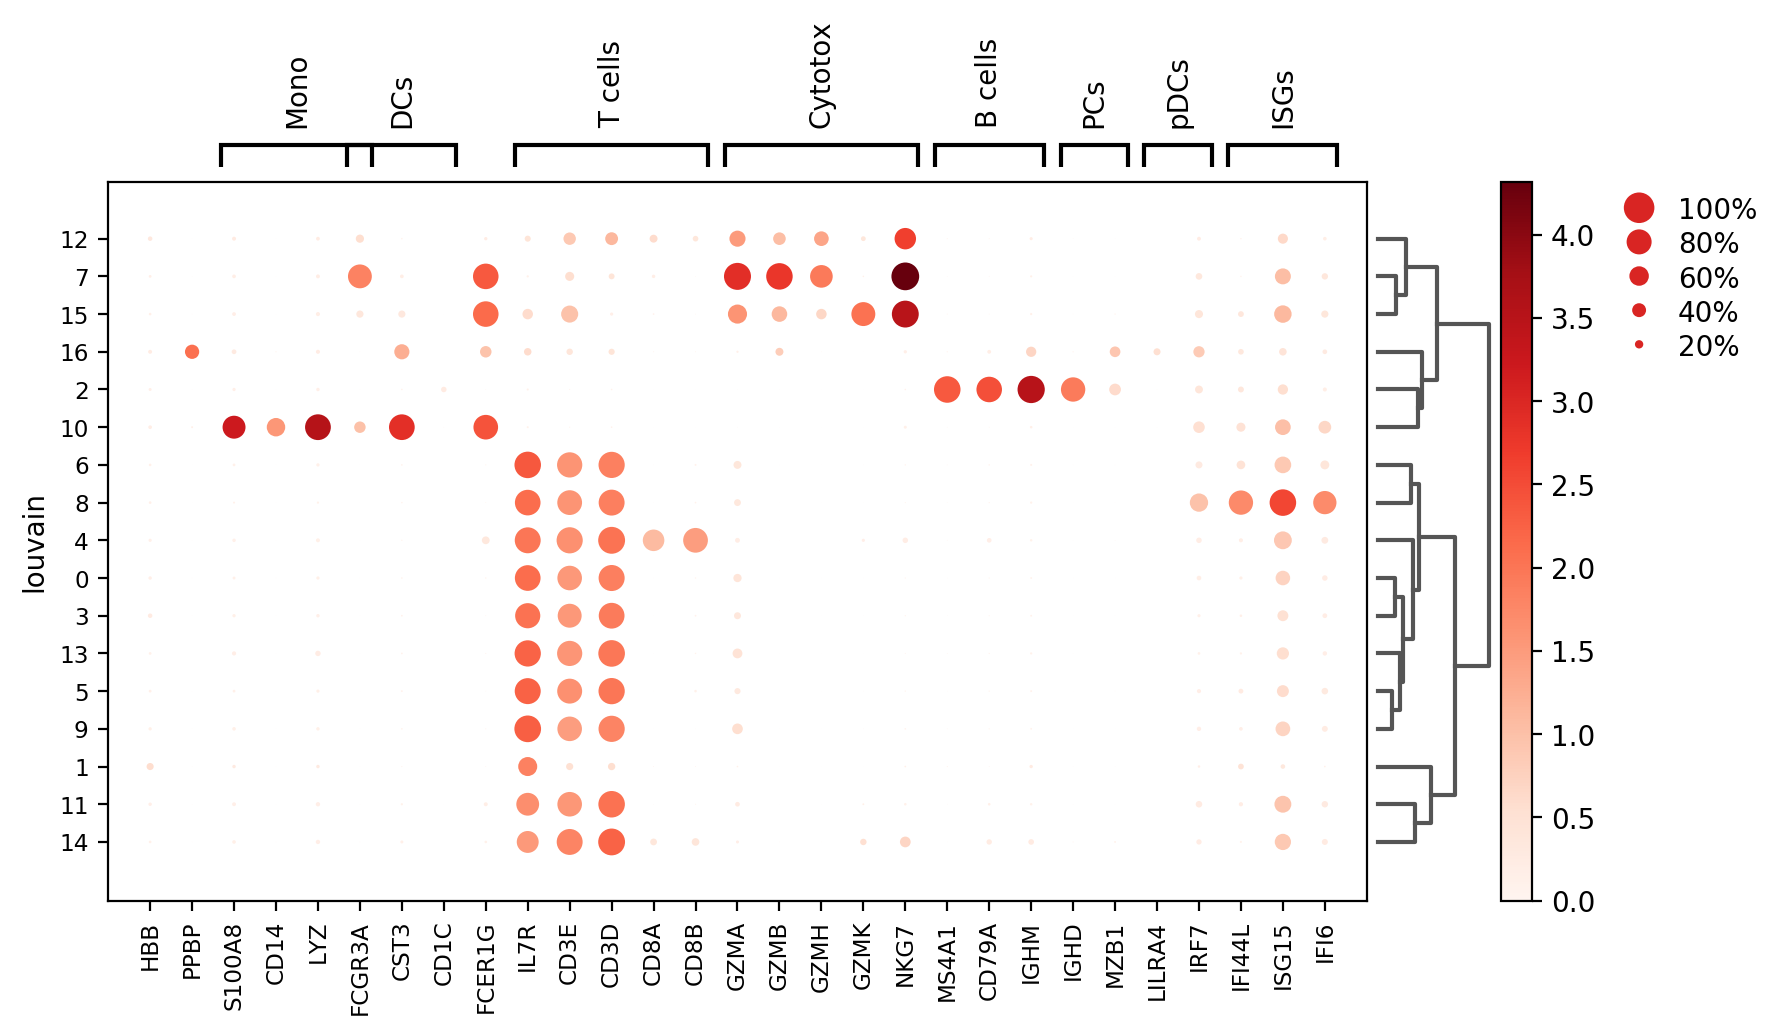

In [74]:

sc.settings.set_figure_params(dpi=300)  # set sufficiently high resolution for saving

Genes =["HBB", "PPBP","S100A8","CD14","LYZ","FCGR3A","CST3",'CD1C',"FCER1G","IL7R","CD3E","CD3D","CD8A","CD8B", 
        "GZMA","GZMB","GZMH","GZMK", "NKG7", "MS4A1", "CD79A",'IGHM',"IGHD","MZB1",'LILRA4',"IRF7",
        'IFI44L','ISG15','IFI6']
matplotlib.style.use('default') 


ax = sc.pl.dotplot(corrected, 
                   Genes, 
                   'louvain', 
                   dendrogram=True,  
                   var_group_positions=[(2,5), (5,7),(9,13),(14,18),(19,21),(22,23),(24,25),(26,28)],
                   var_group_labels=['Mono', 'DCs','T cells','Cytotox','B cells','PCs','pDCs','ISGs'], 
                   figsize=(10,5)) #, save='_Fig1c_LifeSpan') #, save='_Fig1c.pdf'
